In [5]:
%load_ext autoreload
%autoreload 2
%aimport fluidsim
from paths import load_df, paths_sim

# Compose a function to calculate the shock population of one run

In [6]:
from peak_detection import (
    detect_shocks,
    avg_shock_seperation_1d,
    avg_shock_seperation,
    avg_shock_seperation_from_shortname
)

In [7]:
df_w = load_df("df_w")
df_w.head()

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W1,960,10,1.560583e-10,0.0,1.036411,28.834866,0.111188,inf,inf,1.0,2.629674,4.451477,49.88121,noise_c10nh960Buinf
W2,1920,10,9.676842e-13,0.0,1.060045,57.669732,0.112027,inf,inf,1.0,3.014080,4.661181,49.84050,noise_c10nh1920Buinf
W3,3840,10,6.000402e-15,0.0,1.097854,115.339463,0.113343,inf,inf,1.0,3.599781,5.222821,49.85746,noise_c10nh3840Buinf
W4,7680,10,3.724795e-17,0.0,1.175054,230.678927,0.115940,inf,inf,1.0,4.495118,6.116603,16.94066,noise_c10nh7680Buinf
W5,960,20,1.562292e-10,0.0,1.004713,28.834866,0.055021,inf,inf,1.0,3.122627,4.875000,49.86719,noise_c20nh960Buinf


In [8]:
df = df_w[df_w["$n$"] < 4000]
df

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W1,960,10,1.560583e-10,0.0,1.036411,28.834866,0.111188,inf,inf,1.0,2.629674,4.451477,49.88121,noise_c10nh960Buinf
W2,1920,10,9.676842e-13,0.0,1.060045,57.669732,0.112027,inf,inf,1.0,3.014080,4.661181,49.84050,noise_c10nh1920Buinf
W3,3840,10,6.000402e-15,0.0,1.097854,115.339463,0.113343,inf,inf,1.0,3.599781,5.222821,49.85746,noise_c10nh3840Buinf
W5,960,20,1.562292e-10,0.0,1.004713,28.834866,0.055021,inf,inf,1.0,3.122627,4.875000,49.86719,noise_c20nh960Buinf
W6,1920,20,9.687440e-13,0.0,1.017323,57.669732,0.055250,inf,inf,1.0,3.638572,5.614583,119.88200,noise_c20nh1920Buinf
W7,3840,20,6.006974e-15,0.0,1.076911,115.339463,0.056309,inf,inf,1.0,4.493848,6.917684,119.89740,noise_c20nh3840Buinf
W9,960,40,1.560583e-10,0.0,0.995529,28.834866,0.027427,inf,inf,1.0,3.952506,6.015625,49.82943,noise_c40nh960Buinf
W10,1920,40,9.676842e-13,0.0,0.997752,57.669732,0.027447,inf,inf,1.0,4.777498,7.118490,49.82943,noise_c40nh1920Buinf
W11,3840,40,6.000402e-15,0.0,1.064035,115.339463,0.028042,inf,inf,1.0,6.066111,8.722656,49.82943,noise_c40nh3840Buinf
W12,960,100,1.562292e-10,0.0,0.999494,28.834866,0.010985,inf,inf,1.0,5.921388,8.722396,49.83542,noise_c100nh960Buinf


In [9]:
set(df["$n$"])

{960, 1920, 3840}

In [11]:
short = df.iloc[3]["short name"]
paths_sim[short]

'/media/avmo/lacie/13KTH/noise/SW1Lwaves_NOISE2_c=20_L=50.x50._960x960_2016-09-27_18-44-39'

In [12]:
%%capture
from fluidsim import load_state_phys_file

sim = load_state_phys_file(paths_sim[short], merge_missing_params=True)

In [13]:
sim.output.path_run

'/media/avmo/lacie/13KTH/noise/SW1Lwaves_NOISE2_c=20_L=50.x50._960x960_2016-09-27_18-44-39'

Detected 5 peaks


/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


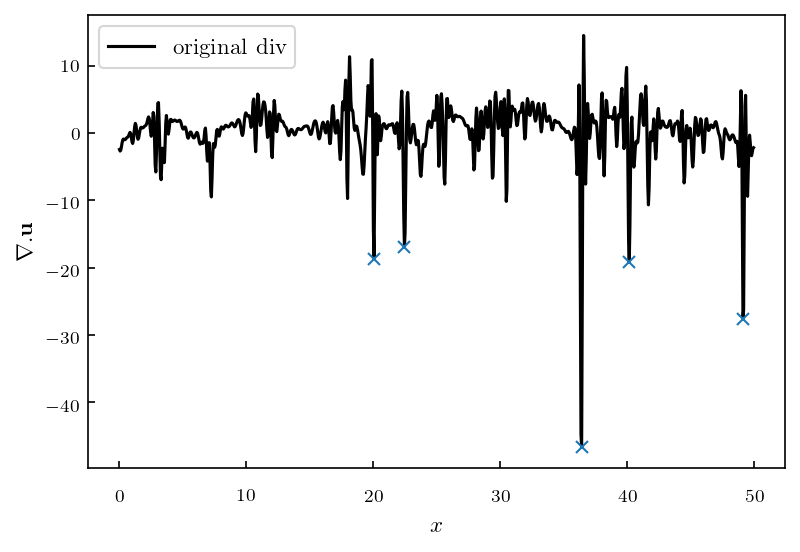

In [15]:
%matplotlib inline
# from scipy.signal import find_peaks, find_peaks_cwt
detect_shocks(sim, sim.oper.nx_seq // 2, debug=True)

In [10]:
avg_shock_seperation_1d(sim, sim.oper.nx // 2)

5.494791666666667

/scratch/avmo/src/latex/augier_vishnu_lindborg_sw1l/Python/peak_detection.py:43: RuntimeWarning: Mean of empty slice.
  return dx_peaks.mean()
/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


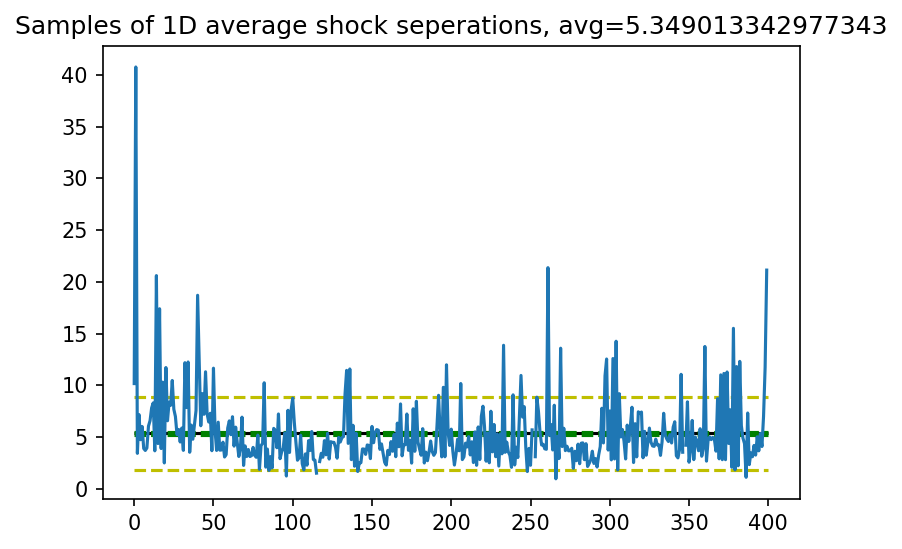

In [11]:
import matplotlib.pyplot as plt
import numpy as np

ds_avg = avg_shock_seperation(sim, 200, averaged=False)
plt.figure(dpi=150)
ds_avg2 = np.nanmean(ds_avg)
ds_std = np.nanstd(ds_avg)
ds_ci = 0.95 * ds_std / (2 * 200) ** 0.5
plt.title(f"Samples of 1D average shock seperations, avg={ds_avg2}")
plt.hlines([ds_avg2], 0, len(ds_avg))
plt.hlines([ds_avg2+ds_std, ds_avg2-ds_std], 0, len(ds_avg), 'y', linestyles='dashed')
plt.hlines([ds_avg2+ds_ci, ds_avg2-ds_ci], 0, len(ds_avg), 'g', linestyles='dashed')
plt.plot(ds_avg)

# Compute inside notebook

In [16]:
%%capture
import pandas as pd
result = df["short name"].apply(avg_shock_seperation_from_shortname).apply(pd.Series)

In [27]:
mean = result[0]
ci = result[1]

In [29]:
from base import _k_f
Lf = np.pi / _k_f(sim.params)
df["shock separation"] = mean / Lf
df["shock separation ci"] = ci / Lf
df.head()

/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name,shock separation,shock separation ci
W1,960,10,1.560583e-10,0.0,1.036411,28.834866,0.111188,inf,inf,1.0,2.629674,4.451477,49.88121,noise_c10nh960Buinf,1.857057,0.072969
W2,1920,10,9.676842e-13,0.0,1.060045,57.669732,0.112027,inf,inf,1.0,3.014080,4.661181,49.84050,noise_c10nh1920Buinf,1.471574,0.049288
W3,3840,10,6.000402e-15,0.0,1.097854,115.339463,0.113343,inf,inf,1.0,3.599781,5.222821,49.85746,noise_c10nh3840Buinf,1.524595,0.047284
W5,960,20,1.562292e-10,0.0,1.004713,28.834866,0.055021,inf,inf,1.0,3.122627,4.875000,49.86719,noise_c20nh960Buinf,1.334979,0.052854
W6,1920,20,9.687440e-13,0.0,1.017323,57.669732,0.055250,inf,inf,1.0,3.638572,5.614583,119.88200,noise_c20nh1920Buinf,1.283763,0.040569


# Load cached data

In [1]:
import pandas as pd
import numpy as np
from paths import load_df
from base import _k_f

df = load_df()
df.set_index("short name", inplace=True, drop=False)
df_shock_sep = pd.read_csv("dataframes/shock_sep.csv", comment="#")
df_shock_sep.set_index("short_name", inplace=True)
df.head()

,$n$,$c$,$\nu_8$,$\nu_2$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
short name,,,,,,,,,,,,,,,
noise_c10nh960Buinf,960,10,1.560583e-10,0.0,0.0,1.036102,28.834866,0.162828,inf,inf,1.0,2.629441,4.451477,49.98453,noise_c10nh960Buinf
noise_c10nh1920Buinf,1920,10,9.676842e-13,0.0,0.0,1.059932,57.669732,0.164067,inf,inf,1.0,3.014007,4.661181,49.94055,noise_c10nh1920Buinf
noise_c10nh3840Buinf,3840,10,6.000402e-15,0.0,0.0,1.098004,115.339463,0.166009,inf,inf,1.0,3.600162,5.222821,49.95841,noise_c10nh3840Buinf
noise_c10nh7680Buinf,7680,10,3.724795e-17,0.0,0.0,1.197907,230.678927,0.170898,inf,inf,1.0,4.522083,6.316804,25.22487,noise_c10nh7680Buinf
noise_c20nh960Buinf,960,20,1.562292e-10,0.0,0.0,1.004686,28.834866,0.080583,inf,inf,1.0,3.122561,4.875000,49.96875,noise_c20nh960Buinf


In [5]:
%%capture
import fluidsim as fs
from paths import paths_sim


sim = fs.load_sim_for_plot(paths_sim[df_shock_sep.iloc[0].name], merge_missing_params=True)
Lf = np.pi / _k_f(sim.params)

In [6]:
df["shock separation"] = df_shock_sep["mean"] / Lf
df.head()

,$n$,$c$,$\nu_8$,$\nu_2$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name,shock separation
short name,,,,,,,,,,,,,,,,
noise_c10nh960Buinf,960,10,1.560583e-10,0.0,0.0,1.036102,28.834866,0.162828,inf,inf,1.0,2.629441,4.451477,49.98453,noise_c10nh960Buinf,1.857057
noise_c10nh1920Buinf,1920,10,9.676842e-13,0.0,0.0,1.059932,57.669732,0.164067,inf,inf,1.0,3.014007,4.661181,49.94055,noise_c10nh1920Buinf,1.471574
noise_c10nh3840Buinf,3840,10,6.000402e-15,0.0,0.0,1.098004,115.339463,0.166009,inf,inf,1.0,3.600162,5.222821,49.95841,noise_c10nh3840Buinf,1.524595
noise_c10nh7680Buinf,7680,10,3.724795e-17,0.0,0.0,1.197907,230.678927,0.170898,inf,inf,1.0,4.522083,6.316804,25.22487,noise_c10nh7680Buinf,1.420856
noise_c20nh960Buinf,960,20,1.562292e-10,0.0,0.0,1.004686,28.834866,0.080583,inf,inf,1.0,3.122561,4.875000,49.96875,noise_c20nh960Buinf,1.334979


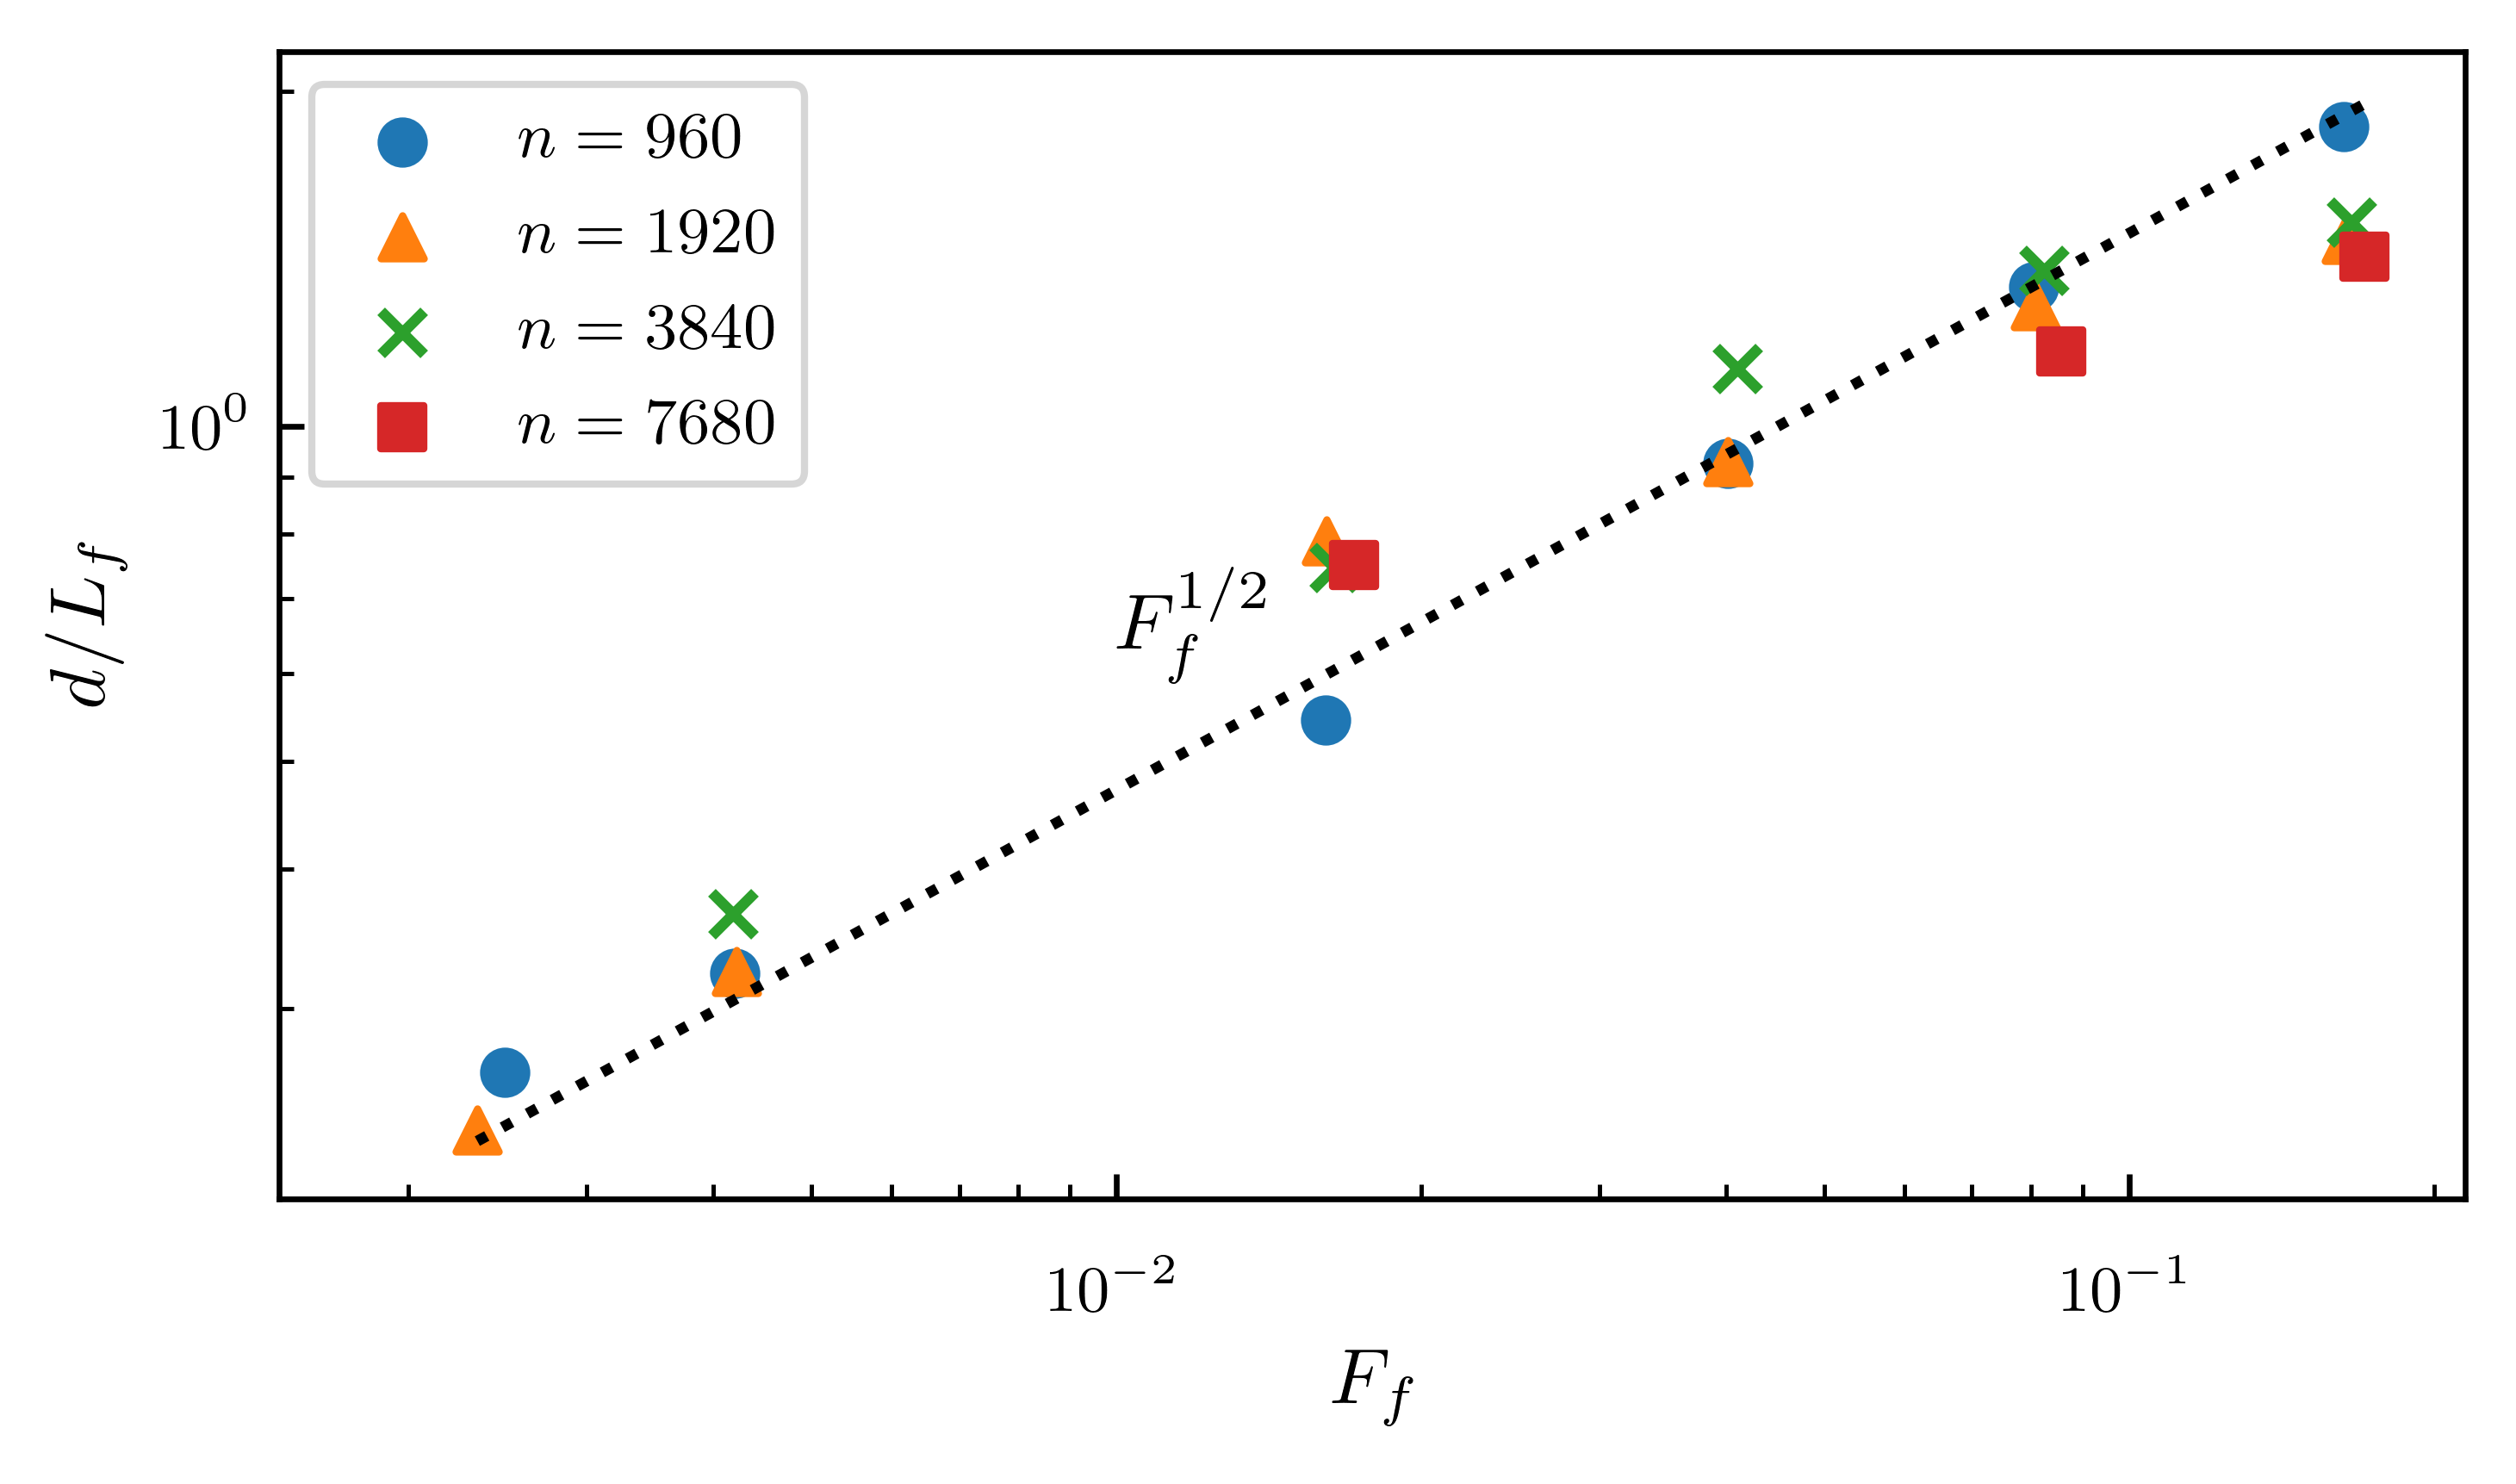

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from base import matplotlib_rc, markers

matplotlib_rc(11)
fig, ax = plt.subplots(figsize=(5,3))
mark = markers()
for n, grp in df.groupby("$n$"):
    ax.scatter(
        r'$F_f$', 'shock separation',
        marker=next(mark),
        #kind="scatter", loglog=True, ax=ax
        data=grp, label=f"$n={n}$")


uniq_F_f = np.array(sorted(set(df[r'$F_f$'])))
ax.loglog(uniq_F_f, 1.5 * np.pi * uniq_F_f ** 0.5, 'k:', label="")

# import seaborn as sns
# sns.regplot(
#     '$F_f$', 'shock separation',
#     data=df,
#     scatter=False, ax=ax, order=2
# )
ax.text(1e-2, 0.6, r"$F_f ^ {1/2}$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('$F_f$')
ax.set_ylabel("$d / L_f$")
ax.legend(fontsize=9)
fig.tight_layout()
plt.show()

In [12]:
fig.savefig("../Pyfig/fig_shock_sep.png")
fig.savefig("../Pyfig/fig_shock_sep.pdf")